# 基于 dmc620 的实时内存带宽测量

`perf stat` 输出文件的路径

In [1]:
perf_raw_path = './stream/dmc620_stream.csv'

## 预处理

从 `perf stat` 输出的 CSV 文件中提取数据，形成数据表

- timestamp 时间戳，每秒一次
- event 事件名
- value 事件计数值

In [2]:
import pandas as pd
import numpy as np

perf_raw_data = pd.read_csv(perf_raw_path,
                            sep='|',
                            header=None, 
                            names=["timestamp", "value", "event"], 
                            usecols=[0, 1, 3])

perf_raw_data

,timestamp,value,event
0,1.001059,146300127,"arm_dmc620_10008c000/clkdiv2_rdwr,mask=1,match=0/"
1,1.001059,146138200,"arm_dmc620_10008c400/clkdiv2_rdwr,mask=1,match=0/"
2,1.001059,146189350,"arm_dmc620_10008c800/clkdiv2_rdwr,mask=1,match=0/"
3,1.001059,146361469,"arm_dmc620_10008cc00/clkdiv2_rdwr,mask=1,match=0/"
4,1.001059,146189372,"arm_dmc620_10008d000/clkdiv2_rdwr,mask=1,match=0/"
...,...,...,...
1723,53.102834,2146,"arm_dmc620_50008cc00/clkdiv2_rdwr,mask=1,match=1/"
1724,53.102834,2290,"arm_dmc620_50008d000/clkdiv2_rdwr,mask=1,match=1/"
1725,53.102834,2227,"arm_dmc620_50008d400/clkdiv2_rdwr,mask=1,match=1/"
1726,53.102834,2250,"arm_dmc620_50008d800/clkdiv2_rdwr,mask=1,match=1/"


处理 event，从 event 中提取出：type 读写类型（read or write），device_id 即 dmc620 在 /sys/devices/ 的编号，socket 即 dmc620 设备所属的 socket

In [3]:
perf_raw_data['type'] = perf_raw_data['event'].apply(
    lambda x: 'read' if x[-2:-1] == '0' else 'write'
)
perf_raw_data['device_id'] = perf_raw_data['event'].apply(
    lambda x: x[11:20]
)
perf_raw_data['socket'] = perf_raw_data['device_id'].apply(
    lambda x: 0 if x[0] == '1' else '1'
)

perf_raw_data = perf_raw_data.drop('event', axis=1)
perf_raw_data

,timestamp,value,type,device_id,socket
0,1.001059,146300127,read,10008c000,0
1,1.001059,146138200,read,10008c400,0
2,1.001059,146189350,read,10008c800,0
3,1.001059,146361469,read,10008cc00,0
4,1.001059,146189372,read,10008d000,0
...,...,...,...,...,...
1723,53.102834,2146,write,50008cc00,1
1724,53.102834,2290,write,50008d000,1
1725,53.102834,2227,write,50008d400,1
1726,53.102834,2250,write,50008d800,1


## 分析

系统整体带宽

对每个时间戳，聚合所有 device 的计数值，求和，乘以 **64 Byte** 再除以时间

> 这里的 G = 10^9

In [4]:
bw_all = perf_raw_data.groupby(['timestamp']).agg(value=('value', 'sum')).reset_index()

bw_all['interval'] = bw_all['timestamp'].diff()
bw_all.loc[0, 'interval'] = bw_all.loc[0, 'timestamp']

bw_all['memory bandwidth (GB/s)'] = (bw_all['value'] * 64) / (bw_all['interval'] * 1000000000)

bw_all

,timestamp,value,interval,memory bandwidth (GB/s)
0,1.001059,3969155872,1.001059,253.757334
1,2.003009,4633736893,1.001951,295.981791
2,3.005795,4541446822,1.002785,289.845257
3,4.007535,4220390869,1.001741,269.635694
4,5.008975,4627230274,1.001440,295.717043
5,6.010358,4849215868,1.001383,309.921215
6,7.011922,4630125283,1.001564,295.865363
7,8.012922,4835430433,1.001000,309.158360
8,9.014416,4632794484,1.001495,296.056345
9,10.015921,4541879554,1.001505,290.243563


单个 dmc620 内存带宽上限

DDR4 数据传输速率 3200 MT/s

宽度 72 bit，其中 64 bit 数据，8 bit ECC 校验

因此单个 DDR4 理论内存带宽

3200 MT/s = 8 B/T = 25600 MB/s = 25.6 GB/s

> 这里 M = 10^6

整机 2 socket 共计 16 个 dmc620，合计最大带宽 

25.6 GB/s * 16 = 409.6 GB/s

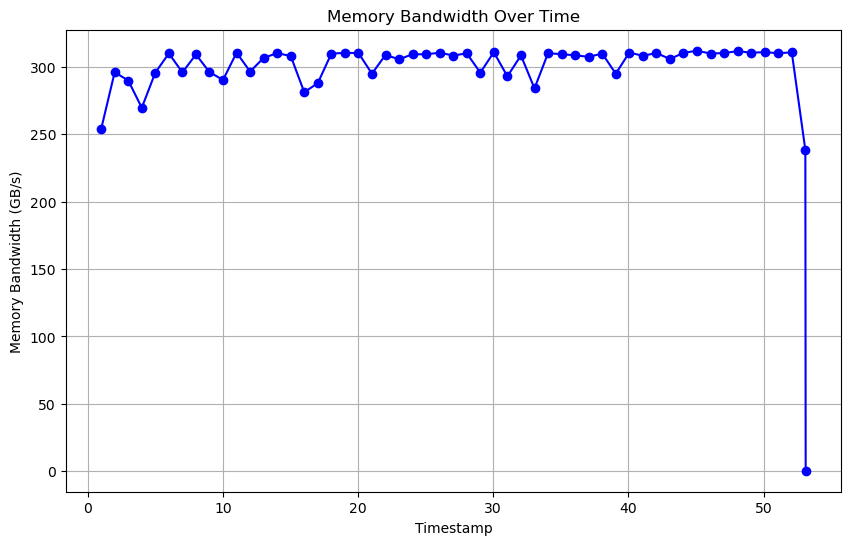

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(bw_all['timestamp'], bw_all['memory bandwidth (GB/s)'], marker='o', linestyle='-', color='b')
plt.title('Memory Bandwidth Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Memory Bandwidth (GB/s)')
plt.grid(True)
plt.show()

In [7]:
max_bandwidth = bw_all['memory bandwidth (GB/s)'].max()
avg_bandwidth = bw_all['memory bandwidth (GB/s)'].iloc[18:52].mean()

max_bandwidth, avg_bandwidth

(311.93470017642676, 307.0607371859204)